哈摟，各位資料科學家大家好，我是來自於台北市"頭期款不足"的阿宏，我想買房子很久了，但是不知道要買哪個地方，想先從內政部不動產交易時價登入資料中先了解行情，我現在手邊蒐集了台北市Taipei(A_lvr_land_A.csv)、新北市New_Taipei(F_lvr_land_A.csv)、台中市Taichung(B_lvr_land_A.csv)、高雄市Kaohsiung(E_lvr_land_A.csv)共四份資料，請各位資料科學家幫幫忙分析了。

# 1.不動產資料檔案讀取並串接

資料分散在4個資料，先合併成一個資料方便後續分析，但是我發現有英文欄位跟中文欄位，留下中文刪除英文，並加入新的欄位用以分辨台北市Taipei、新北市New_Taipei、台中市Taichung、高雄市Kaohsiung

1. 利用Pandas中的pd.read_csv()分別讀取A_lvr_land_A.csv、B_lvr_land_A.csv、E_lvr_land_A.csv、F_lvr_land_A.csv
2. 刪除csv中第二列英文翻譯，The villages and towns urban district,transaction sign,land sector position building sector house number plate,land shifting total area square meter,....
3. 生成city欄位其中以地區分類台北市Taipei(A_lvr_land_A.csv)、新北市New_Taipei(F_lvr_land_A.csv)、台中市Taichung(B_lvr_land_A.csv)、高雄市Kaohsiung(E_lvr_land_A.csv)
4. 將以上四份資料運用pd.concat()串接

In [1]:
import pandas as pd 
from IPython.display import display
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
#1.利用Pandas中的pd.read_csv()分別讀取A_lvr_land_A.csv、B_lvr_land_A.csv、E_lvr_land_A.csv、F_lvr_land_A.csv
#2.刪除csv中第二列英文翻譯，The villages and towns urban district,transaction sign,land sector position building sector house number plate,land shifting total area square meter,....
#3. 生成city欄位其中以地區分類台北市Taipei(A_lvr_land_A.csv)、新北市New_Taipei(F_lvr_land_A.csv)、台中市Taichung(B_lvr_land_A.csv)、高雄市Kaohsiung(E_lvr_land_A.csv)

a_land = pd.read_csv('A_lvr_land_A.csv',skiprows=[1],index_col=None,dtype=str)
a_land['city'] = 'Taipei'
b_land = pd.read_csv('B_lvr_land_A.csv',skiprows=[1],index_col=None,dtype=str)
b_land['city'] = 'Taichung'
e_land = pd.read_csv('E_lvr_land_A.csv',skiprows=[1],index_col=None,dtype=str)
e_land['city'] = 'Kaohsiung'
f_land = pd.read_csv('F_lvr_land_A.csv',skiprows=[1],index_col=None,dtype=str)
f_land['city'] = 'New_Taipei'

#4. 將以上四份資料運用pd.concat()串接
lands = pd.concat([a_land,b_land,e_land,f_land])
lands.head(1)


,鄉鎮市區,交易標的,土地區段位置建物區段門牌,土地移轉總面積平方公尺,都市土地使用分區,非都市土地使用分區,非都市土地使用編定,交易年月日,交易筆棟數,移轉層次,...,車位類別,車位移轉總面積(平方公尺),車位總價元,備註,編號,主建物面積,附屬建物面積,陽台面積,電梯,city
0,文山區,房地(土地+建物)+車位,臺北市文山區忠順街二段85巷1~30號,26.97,住,NaN,NaN,1090406,土地1建物1車位2,四層,...,坡道平面,40.7,0,含增建或未登記建物。;內含獨立產權車位，未包含在棟數內。,RPVOMLMKNHPFFAA18CA,110.91,9.63,11.09,NaN,Taipei


# 2. 資料清理與切片

因為我是想買來住的房子，所以幫忙刪除住宿用途以外的資料，並且限制
1. 交易年月日，限制在109年
2. 建物現況格局-房，1~5間 
3. 建物現況格局-廳，1~2廳

以下columns_mapping、analysis_columns、columns_type提供給資料科學家配合使用
1. 利用.rename()並配合以下columns_mapping，將原中文欄位名稱改為英文方便之後分析
2. 取出主要用途(main_use)為'住家用'以及都市土地使用分區(use_zoning)為'住'的資料並針對以下欄位analysis_columns做分析並去除na值
   (提示:先取完之後再.dropna())
3. 觀察欄位資料型態，並利用.astype()搭配以下提供的columns_type做欄位型態轉換
4. 做資料切片將<br>
    新增欄位交易年月日(tx_dt_year)，從交易年月日(tx_dt)萃取出年份<br>
    1.交易年月日(tx_dt_year)，限制在109年<br>
    2.建物現況格局-房(room_number)，限制在1到5間<br>
    3.建物現況格局-廳(hall_number)，限制在1到2廳<br>
    4.最後運用.reset_index()重新定義索引

In [3]:
columns_mapping = {
'交易標的':'transaction_sign',
'土地區段位置建物區段門牌':'house_number',
'土地移轉總面積平方公尺':'land_area_square_meter', 
'都市土地使用分區':'use_zoning', 
'非都市土地使用分區':'land_use_district',
'非都市土地使用編定':'land_use',
'交易年月日':'tx_dt', 
 '交易筆棟數':'transaction_pen_number', 
 '移轉層次':'shifting_level', 
 '總樓層數':'total_floor_number', 
 '建物型態':'building_state', 
 '主要用途':'main_use', 
 '主要建材':'main_materials',
 '建築完成年月':'complete_date', 
 '建物移轉總面積平方公尺':'building_area_square_meter', 
 '建物現況格局-房':'room_number', 
 '建物現況格局-廳':'hall_number', 
 '建物現況格局-衛':'health_number', 
'建物現況格局-隔間':'compartmented_number', 
 '有無管理組織':'manages', 
 '總價元':'total_price', 
 '單價元平方公尺':'unit_price', 
 '車位類別':'berth_category', 
 '車位移轉總面積(平方公尺)':'berth_area_square_meter',
'車位總價元':'berth_price', 
 '備註':'note', 
 '編號':'serial_number', 
 '主建物面積':'main_building_area', 
 '附屬建物面積':'auxiliary_building_area', 
 '陽台面積':'balcony_area', 
 '電梯':'elevator','鄉鎮市區':'towns',
                  }
analysis_columns = ['city','towns','main_use','use_zoning','total_price','building_area_square_meter',
                                     'main_building_area',
                                     'tx_dt','unit_price','room_number','hall_number','health_number']
columns_type = {'total_price': 'int','unit_price':'float','building_area_square_meter':'float',
                                      'main_building_area': 'float',
                                      'room_number': 'int','hall_number': 'int','health_number': 'int'}

In [4]:
#1. 利用.rename()並配合以下columns_mapping，將原中文欄位名稱改為英文方便之後分析
#lands.rename(columns=columns_mapping,inplace=True)
lands2 = lands.rename(columns=columns_mapping)
lands = lands2.rename(columns={lands.columns[0]:'towns'})
lands.head(1)


,towns,transaction_sign,house_number,land_area_square_meter,use_zoning,land_use_district,land_use,tx_dt,transaction_pen_number,shifting_level,...,berth_category,berth_area_square_meter,berth_price,note,serial_number,main_building_area,auxiliary_building_area,balcony_area,elevator,city
0,文山區,房地(土地+建物)+車位,臺北市文山區忠順街二段85巷1~30號,26.97,住,NaN,NaN,1090406,土地1建物1車位2,四層,...,坡道平面,40.7,0,含增建或未登記建物。;內含獨立產權車位，未包含在棟數內。,RPVOMLMKNHPFFAA18CA,110.91,9.63,11.09,NaN,Taipei


In [5]:
#2. 取出主要用途(main_use)為'住家用'以及都市土地使用分區(use_zoning)為'住'的資料並針對以下欄位analysis_columns做分析並去除na值 (提示:先取完之後再.dropna())
#   (提示:先取完之後再.dropna())
lands = lands[(lands['main_use']=='住家用') & (lands['use_zoning']=='住')]
lands.dropna(subset=analysis_columns, inplace=True)

In [6]:
#3. 觀察欄位資料型態，並利用.astype()搭配以下提供的columns_type做欄位型態轉換
for k,v in columns_type.items():
    lands[k] = lands[k].astype(v)
lands.dtypes

towns                          object
transaction_sign               object
house_number                   object
land_area_square_meter         object
use_zoning                     object
land_use_district              object
land_use                       object
tx_dt                          object
transaction_pen_number         object
shifting_level                 object
total_floor_number             object
building_state                 object
main_use                       object
main_materials                 object
complete_date                  object
building_area_square_meter    float64
room_number                     int32
hall_number                     int32
health_number                   int32
compartmented_number           object
manages                        object
total_price                     int32
unit_price                    float64
berth_category                 object
berth_area_square_meter        object
berth_price                    object
note        

In [7]:
#4. 做資料切片將
#     新增欄位交易年月日(tx_dt_year)，從交易年月日(tx_dt)萃取出年份
#     1.交易年月日(tx_dt_year)，限制在109年
#     2.建物現況格局-房(room_number)，限制在1到5間
#     3.建物現況格局-廳(hall_number)，限制在1到2廳
#     4.最後運用.reset_index()重新定義索引
lands['tx_dt_year']=lands['tx_dt'].str.slice(start=0,stop=3)
lands = lands[(lands['tx_dt_year']=='109')  & (lands['room_number']<=5) 
              & (lands['room_number']>=1) & (lands['hall_number']<=2) & (lands['hall_number']>=1)]
lands.reset_index(inplace=True)
lands.head(1)

,index,towns,transaction_sign,house_number,land_area_square_meter,use_zoning,land_use_district,land_use,tx_dt,transaction_pen_number,...,berth_area_square_meter,berth_price,note,serial_number,main_building_area,auxiliary_building_area,balcony_area,elevator,city,tx_dt_year
0,0,文山區,房地(土地+建物)+車位,臺北市文山區忠順街二段85巷1~30號,26.97,住,NaN,NaN,1090406,土地1建物1車位2,...,40.7,0,含增建或未登記建物。;內含獨立產權車位，未包含在棟數內。,RPVOMLMKNHPFFAA18CA,110.91,9.63,11.09,NaN,Taipei,109


# 3. 建立自定義特徵加入分析


以台灣來說大家都是以坪為單位計算使用面積，應該是不會問說你家有幾平方公尺吧?，但是偏偏資料中沒有以坪為單位計算，所以接下來請各位幫忙產生新的欄位以坪為單位計算面積，轉換公式我也幫你找好了，在下面的定義。<br>
定義 : 1平方公尺相當於0.3025坪 <br>
建立新特徵
1. 建物移轉總面積坪(building_area_square_feet) : 建物移轉總面積平方公尺\*0.3025
2. 主建物面積坪(main_building_area_square_feet) : 主建物面積\*0.3025
3. 單價元坪(unit_price_square_feet) : 單價元平方公尺/0.3025

可以利用.describe()做一下資料觀察，是否有奇怪的資料?<br>
如果有請將資料移除，並說明為什麼移除此資料?<br>
移除後再用.describe()觀察是否還有奇怪的資料?

In [8]:
# 建立新特徵
# 1. 建物移轉總面積坪(building_area_square_feet) : 建物移轉總面積平方公尺*0.3025
# 2. 主建物面積坪(main_building_area_square_feet) : 主建物面積*0.3025
# 3. 單價元坪(unit_price_square_feet) : 單價元平方公尺/0.3025
lands['building_area_square_feet'] = lands['building_area_square_meter']*0.3025
lands['main_building_area_square_feet'] = lands['main_building_area']*0.3025
lands['unit_price_square_feet'] = lands['unit_price']*0.3025

In [9]:
# 可以利用.describe()做一下資料觀察，是否有奇怪的資料?
# 如果有請將資料移除，並說明為什麼移除此資料?
display(lands[ (lands['total_price']==0) | (lands['main_building_area']==0) ])
new_lands = lands.drop(lands[ (lands['total_price']==0) | (lands['main_building_area']==0) ].index)


,index,towns,transaction_sign,house_number,land_area_square_meter,use_zoning,land_use_district,land_use,tx_dt,transaction_pen_number,...,serial_number,main_building_area,auxiliary_building_area,balcony_area,elevator,city,tx_dt_year,building_area_square_feet,main_building_area_square_feet,unit_price_square_feet
325,858,士林區,房地(土地+建物),臺北市士林區中山北路七段14巷61弄1~30號,0.31,住,NaN,NaN,1090504,土地1建物1車位0,...,RPTPMLPLNHPFFEA88CA,0.0,0.0,0.0,NaN,Taipei,109,0.353925,0.0,38782.0125
928,2456,北投區,房地(土地+建物),臺北市北投區同德街44巷1~30號,0.28,住,NaN,NaN,1090608,土地1建物1車位0,...,RPOPMLTKOHPFFEA78CA,0.0,0.0,0.0,NaN,Taipei,109,0.293425,0.0,0.0000
1935,3032,西屯區,房地(土地+建物)+車位,臺中市西屯區皇城街1~30號,33.59,住,NaN,NaN,1090518,土地1建物1車位1,...,RPTQMLNJOHPFFCB58CA,0.0,0.0,0.0,NaN,Taichung,109,64.232850,0.0,15670.7100
2030,3432,北區,房地(土地+建物),臺中市北區大德街82巷1~30號,23.8,住,NaN,NaN,1090503,土地1建物1車位0,...,RPURMLQKOHPFFBB09CA,0.0,0.0,0.0,NaN,Taichung,109,22.681450,0.0,17993.6075
2441,5823,南區,房地(土地+建物),臺中市南區忠明南路871~900號,0.14,住,NaN,NaN,1090604,土地1建物1車位0,...,RPTRMLMLPHPFFAB88EA,0.0,0.0,0.0,NaN,Taichung,109,0.650375,0.0,14069.8800
2540,6326,北屯區,房地(土地+建物),臺中市北屯區松竹路337巷1~30號,14.58,住,NaN,NaN,1090603,土地1建物1車位0,...,RPVWMLMLPHPFFBB86CA,0.0,0.0,0.0,NaN,Taichung,109,36.439150,0.0,13485.1475
2699,7195,北屯區,房地(土地+建物),臺中市北屯區崇德路三段317巷124弄31~60號,79.2,住,NaN,NaN,1090527,土地3建物1車位0,...,RPTUMLQJPHPFFBB66CA,0.0,0.0,0.0,NaN,Taichung,109,69.735325,0.0,0.0000
3088,2137,楠梓區,房地(土地+建物)+車位,高雄市楠梓區土庫二路181~210號,7.77,住,NaN,NaN,1090513,土地2建物1車位1,...,RPWSMLQJPHPFFEE47DA,0.0,0.0,0.0,NaN,Kaohsiung,109,21.035850,0.0,16750.0300
3357,3603,鳳山區,房地(土地+建物),高雄市鳳山區光復路二段331~360號,6.8,住,NaN,NaN,1090513,土地1建物1車位0,...,RPRPMLRJPHPFFGE96DA,0.0,0.0,0.0,NaN,Kaohsiung,109,13.884750,0.0,13444.3100
3400,3867,楠梓區,房地(土地+建物),高雄市楠梓區德民路811~840號,9.81,住,NaN,NaN,1090520,土地1建物1車位0,...,RPSOMLKMOHPFFEE78CA,0.0,0.0,0.0,NaN,Kaohsiung,109,26.078525,0.0,10526.6975


In [10]:
# 移除後再用.describe()觀察是否還有奇怪的資料?
new_lands.describe()


,index,building_area_square_meter,room_number,hall_number,health_number,total_price,unit_price,main_building_area,building_area_square_feet,main_building_area_square_feet,unit_price_square_feet
count,6854.000000,6854.000000,6854.000000,6854.000000,6854.000000,6.854000e+03,6854.000000,6854.000000,6854.000000,6854.000000,6854.000000
mean,3396.218413,121.768404,2.849869,1.793114,1.733149,1.141669e+07,94548.453020,82.565725,36.834942,24.976132,28600.907039
std,2216.664527,62.849105,0.898343,0.405103,0.680869,1.161669e+07,58374.690321,36.940424,19.011854,11.174478,17658.343822
min,0.000000,7.440000,1.000000,1.000000,0.000000,4.100000e+05,3239.000000,7.440000,2.250600,2.250600,979.797500
25%,1576.250000,83.012500,2.000000,2.000000,1.000000,5.600000e+06,53597.250000,61.062500,25.111281,18.471406,16213.168125
50%,3081.500000,109.405000,3.000000,2.000000,2.000000,8.600000e+06,79742.500000,79.110000,33.095012,23.930775,24122.106250
75%,5089.250000,147.445000,3.000000,2.000000,2.000000,1.330000e+07,118880.000000,95.970000,44.602112,29.030925,35961.200000
max,12632.000000,1444.950000,5.000000,2.000000,6.000000,2.250000e+08,610104.000000,335.760000,437.097375,101.567400,184556.460000


# 4. 找出台北市時價登入總價高度相關的變數

阿宏我是台北人他想找出影響台北市總價、單價元坪的因子<br>
相關係數0.3以下為低相關，0.3\~0.7為中等相關，0.7以上為高度相關<br>
1. 資料切片切出city欄位為台北市的資料，並找出時價登入總價(total_price)高度相關的變數
2. 資料切片切出city欄位為台北市的資料，找出單價元坪(unit_price_square_feet)高度相關的變數

In [11]:
def corr_degree(cor_val):
    if cor_val < 0.3:
        return 'Low'
    elif cor_val >=0.3 and cor_val <= 0.7:
        return 'Medium'
    elif cor_val > 0.7:
        return 'High'

In [12]:
# 阿宏我是台北人他想找出影響台北市總價、單價元坪的因子
# 1. 資料切片切出city欄位為台北市的資料，並找出時價登入總價(total_price)高度相關的變數

c_idx = 'total_price'
tpe_total_price_corr = new_lands[new_lands['city']=='Taipei'].corr()[c_idx]
for idx in tpe_total_price_corr.index:
    if idx == c_idx or idx == 'index':
        continue
    print("{3} => {0} <--> {1} ~ {2}".format(c_idx,idx,tpe_total_price_corr[idx],corr_degree(tpe_total_price_corr[idx])))
print()

c_idx = 'unit_price_square_feet'
# 2. 資料切片切出city欄位為台北市的資料，找出單價元坪(unit_price_square_feet)高度相關的變數
tpe_unit_price_sqr_ft_corr = new_lands[new_lands['city']=='Taipei'].corr()[c_idx]
for idx in tpe_total_price_corr.index:
    if idx == c_idx or idx == 'index':
        continue    
    print("{3} => {0} <--> {1} ~ {2}".format(c_idx,idx,tpe_total_price_corr[idx],corr_degree(tpe_total_price_corr[idx])))


High => total_price <--> building_area_square_meter ~ 0.8646266775371659
Medium => total_price <--> room_number ~ 0.32644140019099305
Low => total_price <--> hall_number ~ 0.27078673622229615
Medium => total_price <--> health_number ~ 0.5988317082017817
Medium => total_price <--> unit_price ~ 0.5812901524655665
High => total_price <--> main_building_area ~ 0.7105154108206199
High => total_price <--> building_area_square_feet ~ 0.8646266775371668
High => total_price <--> main_building_area_square_feet ~ 0.7105154108206179
Medium => total_price <--> unit_price_square_feet ~ 0.581290152465566

High => unit_price_square_feet <--> building_area_square_meter ~ 0.8646266775371659
Medium => unit_price_square_feet <--> room_number ~ 0.32644140019099305
Low => unit_price_square_feet <--> hall_number ~ 0.27078673622229615
Medium => unit_price_square_feet <--> health_number ~ 0.5988317082017817
High => unit_price_square_feet <--> total_price ~ 1.0
Medium => unit_price_square_feet <--> unit_price ~

# 5. 資料視覺化並解釋


我想要以視覺化的方式來看房價資料，並且請各位資料科學家解釋圖表給阿宏我知道
1. 以城市(city)為x軸，以單價元坪(unit_price_square_feet)為y軸畫出boxplot，並找出單價元坪(unit_price_square_feet)中位數最高的地區
2. 進一步對台北市的資料做圖，以建物現況格局-房(room_number)為x軸，以總價元(total_price)為y軸畫出boxplot，並找出總價元(total_price)中位數最高的房間數。hint:資料切片找出city欄位為台北市的資料，再進一步畫圖
3. 對台北市的資料做圖，先將地區(twons)做編碼在進行，再以地區(twon)為x軸，以單價元坪(unit_price_square_feet)為y軸畫出boxplot，並找出單價元坪(unit_price_square_feet)中位數最高的地區。hint:運用LabelEncoder()對地區(twons)做編碼，運用.inverse_transform()反查編碼的地區

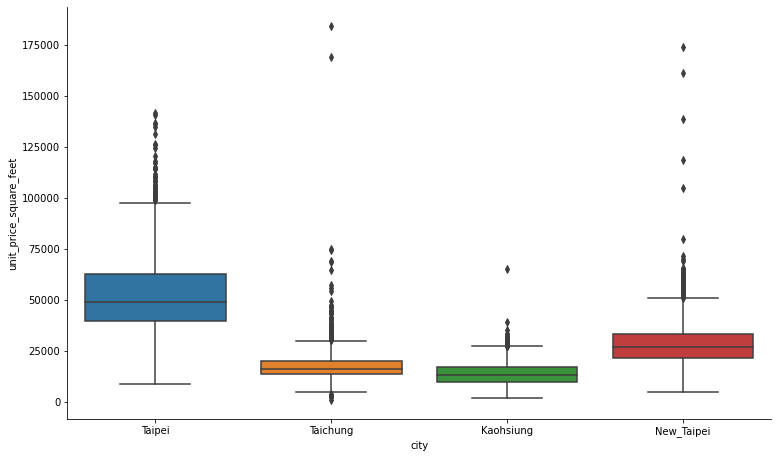

In [13]:
#1. 以城市(city)為x軸，以單價元坪(unit_price_square_feet)為y軸畫出boxplot，並找出單價元坪(unit_price_square_feet)中位數最高的地區
sns.catplot(x='city', y='unit_price_square_feet', data=new_lands, kind='box', height=6.27, aspect=10.7/6.27)


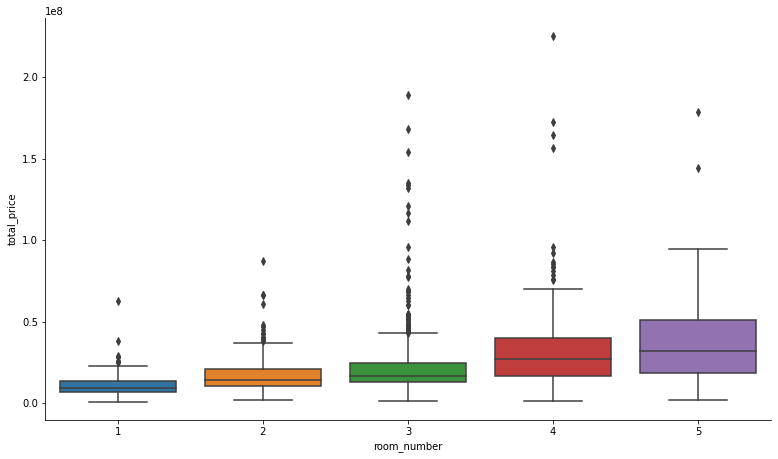

In [14]:
#2. 進一步對台北市的資料做圖，以建物現況格局-房(room_number)為x軸，以總價元(total_price)為y軸畫出boxplot，並找出總價元(total_price)中位數最高的房間數。hint:資料切片找出city欄位為台北市的資料，再進一步畫圖
tpe_lands = new_lands[new_lands['city']=='Taipei']
sns.catplot(x='room_number', y='total_price', data=tpe_lands, kind='box', height=6.27, aspect=10.7/6.27)

In [15]:
#3. 對台北市的資料做圖，先將地區(twons)做編碼在進行，再以地區(twon)為x軸，以單價元坪(unit_price_square_feet)為y軸畫出boxplot，並找出單價元坪(unit_price_square_feet)中位數最高的地區。
# hint:運用LabelEncoder()對地區(twons)做編碼，運用.inverse_transform()反查編碼的地區
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
tpe_lands['towns_a'] = le.fit_transform(tpe_lands['towns'])
tpe_lands.head()

,index,towns,transaction_sign,house_number,land_area_square_meter,use_zoning,land_use_district,land_use,tx_dt,transaction_pen_number,...,main_building_area,auxiliary_building_area,balcony_area,elevator,city,tx_dt_year,building_area_square_feet,main_building_area_square_feet,unit_price_square_feet,towns_a
0,0,文山區,房地(土地+建物)+車位,臺北市文山區忠順街二段85巷1~30號,26.97,住,NaN,NaN,1090406,土地1建物1車位2,...,110.91,9.63,11.09,NaN,Taipei,109,69.547775,33.550275,47366.3575,9
1,1,文山區,房地(土地+建物),臺北市文山區福興路91~120號,10.32,住,NaN,NaN,1090317,土地1建物1車位0,...,24.58,1.28,2.3,NaN,Taipei,109,11.286275,7.435450,45241.2950,9
2,4,文山區,房地(土地+建物),臺北市文山區樟新街56巷1~30號,44.57,住,NaN,NaN,1090328,土地3建物1車位0,...,98.74,2.26,11.84,NaN,Taipei,109,37.407150,29.868850,44717.0625,9
3,6,文山區,房地(土地+建物),臺北市文山區木柵路四段159巷170弄1~30號,30.65,住,NaN,NaN,1090417,土地2建物1車位0,...,90.78,11.51,12.93,NaN,Taipei,109,37.585625,27.460950,19476.7650,9
4,7,文山區,房地(土地+建物),臺北市文山區興隆路三段112巷4弄1~30號,9.84,住,NaN,NaN,1090417,土地1建物1車位0,...,26.15,0.0,4.01,NaN,Taipei,109,9.123400,7.910375,22065.5600,9


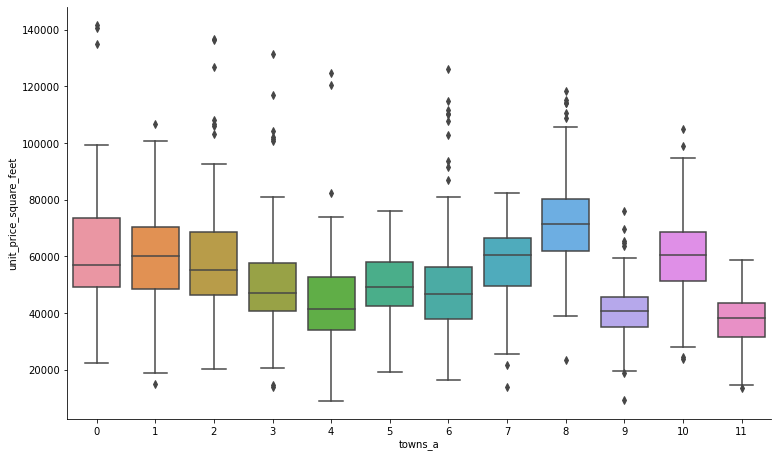

In [16]:
sns.catplot(x='towns_a', y='unit_price_square_feet', data=tpe_lands, kind='box', height=6.27, aspect=10.7/6.27)

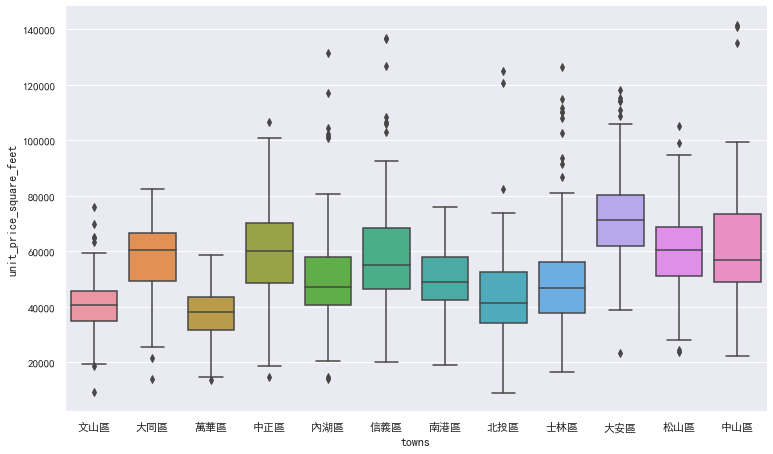

In [17]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf',size=14)
sns.set(font=myfont.get_name())
sns.catplot(x='towns', y='unit_price_square_feet', data=tpe_lands, kind='box', height=6.27, aspect=10.7/6.27)

In [18]:
le.inverse_transform([8])

array(['大安區'], dtype=object)